 This notebook has few dependencies which lack of pre-built binaries on Windows. I recommend testing this script on Linux with following setup:

 1. Build [ampas/CTL](https://github.com/ampas/CTL).
    We need to use ctlrender to generate sample images of color transformation

 2. Clone repository of [ampas/aces-dev](https://github.com/ampas/aces-dev) and set the directory which contains ctl files to CTL_ROOT_DIRECTORY
 3. Install [colour-science package](https://www.colour-science.org/installation-guide/)
    ```bash
       pip install colour-science
       pip install imageio
    ```
 > Don't install these packages from conda install! That version doesn't have image read/write of imageio. I've tried to install OpenImageIO, but it seems that the distributed module doesn't have Python binding.

 4. Execute commands below to install FreeImage plugin. We need it to read/write OpenEXR.
    ```bash
       python -c "import imageio;imageio.plugins.freeimage.download()"
    ```

In [4]:
import colour
import matplotlib.pyplot as plt
import numpy as np
import os
import scipy
import subprocess

IO_DIRECTORY = 'images'
CTL_ROOT_DIRECTORY = '../aces-dev/transforms/ctl'
os.environ['CTL_MODULE_PATH'] = os.path.join(CTL_ROOT_DIRECTORY, 'lib')

def ctlrender(in_filepath, out_filepath, ctls):
    """Use external console tool 'ctlrender' to render an image."""
    args = ['ctlrender']
    for c in ctls:
        args.append('-ctl')
        args.append(c)

    args.append(in_filepath)
    args.append(out_filepath)
    args.append('-verbose -force')

    output = subprocess.check_output(' '.join(args), stderr=subprocess.STDOUT, shell=True)
    return output


In [5]:
# Minimum and maximum representable number for 16-bit float
MINIMUM_REPR_NUMBER = 5.96e-08
MAXIMUM_REPR_NUMBER = 65504

DEFAULT_SAMPLE_COUNT = 16384

log_dist_samples = np.logspace(np.log10(MINIMUM_REPR_NUMBER), 
                               np.log10(MAXIMUM_REPR_NUMBER), 
                               DEFAULT_SAMPLE_COUNT)

def write_image(path, samples):
    a = samples[np.newaxis, ...]
    a = colour.utilities.tstack((a, a, a))
    colour.write_image(a, path, method='Imageio')

log_ramp_img_path = os.path.join(IO_DIRECTORY, 'log_ramp.exr')
write_image(log_ramp_img_path, log_dist_samples)


Achromic MSE: 0.0010884524040665178, Coeffs: [ 180.08877305    5.82507674  190.14106451   56.89654471   53.22517853]


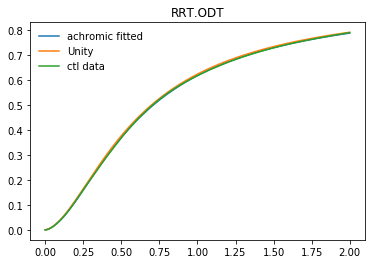

In [6]:
def get_sampler(in_xdata, in_image_path, out_image_name, ctl_list):
    out_image_path = os.path.join(IO_DIRECTORY, out_image_name)
    ctlrender(in_image_path, out_image_path, ctl_list)
    ydata = colour.read_image(out_image_path, method='Imageio')[..., 0].ravel()    # flatten to 1D array
    return colour.LinearInterpolator(in_xdata, ydata)

# Polynomial curve function to fit tone mapping.
def func(x, a, b, c, d, e):
    return (x * (a * x + b)) / (x * (c * x + d) + e)

# We compose the achromic parts of RRT and ODT together. We use a polynomial curve to represent such transformation, thus we could use in fragement shader.
achromic_sampler = get_sampler(log_dist_samples, log_ramp_img_path, 
                             'RRTODT_log_ramp.exr', 
                             ['ext/ctl/RRTODT.ctl'])

xdata = np.linspace(log_dist_samples[0], 2, DEFAULT_SAMPLE_COUNT / 4)
ydata = achromic_sampler(xdata)
popt, pcov = scipy.optimize.curve_fit(func, xdata, ydata)

# This is another fitting from https://github.com/colour-science/colour-unity/blob/master/Assets/Colour/Notebooks/CIECAM02_Unity.ipynb
coeffs = [278.508452016034312, 10.777173236228062, 293.604480035671997, 88.712248853759547, 80.688937129502875]

plt.title('RRT.ODT')
plt.plot(xdata, func(xdata, *popt), label='achromic fitted')
plt.plot(xdata, func(xdata, *coeffs), label='Unity')
plt.plot(xdata, ydata, label='ctl data')
plt.legend(loc='upper left', frameon=False)

diff = ydata - func(xdata, *popt)
mean_square_error = np.sqrt(diff ** 2).mean()
print('Achromic MSE: {}, Coeffs: {}'.format(mean_square_error, popt))


 If you want to fit entire RRT + Rec.709 ODT, you could try this:
 ``` python
 rrt_ctl = os.path.join(CTL_ROOT_DIRECTORY, 'rrt', 'RRT.ctl')
 rec709_100nits_ctl = os.path.join(CTL_ROOT_DIRECTORY, 'odt', 'rec709', 'ODT.Academy.Rec709_100nits_dim.ctl')
 rec709_sampler = get_sampler(log_dist_samples, log_ramp_img_path,
                              'RRTODT_rec709_log_ramp.exr',
                              [rrt_ctl, rec709_100nits_ctl])
 ```